Importing libraries

In [1]:
import streamlit as st
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mysql.connector
import datetime as dt
from dateutil.relativedelta import relativedelta
import calendar

Sales Query

In [2]:
#connection to mysql
connection = mysql.connector.connect(user = 'toyscie', password = 'WILD4Rdata!', host = '51.178.25.157', port = '23456', database = 'toys_and_models', use_pure = True)
query_sales = """
    SELECT YEAR(o.orderDate) AS Sales_Year, 
           MONTH(o.orderDate) AS Sales_Month, 
           SUM(CASE WHEN p.productLine = 'Motorcycles' THEN od.quantityOrdered ELSE 0 END) AS Motorcycles_Sales, 
           SUM(CASE WHEN p.productLine = 'Classic Cars' THEN od.quantityOrdered ELSE 0 END) AS Classic_Cars_Sales, 
           SUM(CASE WHEN p.productLine = 'Trucks and Buses' THEN od.quantityOrdered ELSE 0 END) AS Trucks_Buses_Sales, 
           SUM(CASE WHEN p.productLine = 'Vintage Cars' THEN od.quantityOrdered ELSE 0 END) AS Vintage_Cars_Sales, 
           SUM(CASE WHEN p.productLine = 'Planes' THEN od.quantityOrdered ELSE 0 END) AS Planes_Sales, 
           SUM(CASE WHEN p.productLine = 'Trains' THEN od.quantityOrdered ELSE 0 END) AS Trains_Sales, 
           SUM(CASE WHEN p.productLine = 'Ships' THEN od.quantityOrdered ELSE 0 END) AS Ships_Sales, 
           LAG(SUM(CASE WHEN p.productLine = 'Motorcycles' THEN od.quantityOrdered ELSE 0 END), 12) OVER (ORDER BY YEAR(o.orderDate), MONTH(o.orderDate)) AS Motorcycles_Sales_PY,
           LAG(SUM(CASE WHEN p.productLine = 'Classic Cars' THEN od.quantityOrdered ELSE 0 END), 12) OVER (ORDER BY YEAR(o.orderDate), MONTH(o.orderDate)) AS Ccs_PreviousYear, 
           LAG(SUM(CASE WHEN p.productLine = 'Trucks and Buses' THEN od.quantityOrdered ELSE 0 END), 12) OVER (ORDER BY YEAR(o.orderDate), MONTH(o.orderDate)) AS Trucks_Buses_Sales_PreviousYear, 
           LAG(SUM(CASE WHEN p.productLine = 'Vintage Cars' THEN od.quantityOrdered ELSE 0 END), 12) OVER (ORDER BY YEAR(o.orderDate), MONTH(o.orderDate)) AS Vintage_Cars_Sales_PreviousYear, 
           LAG(SUM(CASE WHEN p.productLine = 'Planes' THEN od.quantityOrdered ELSE 0 END), 12) OVER (ORDER BY YEAR(o.orderDate), MONTH(o.orderDate)) AS Planes_Sales_PreviousYear, 
           LAG(SUM(CASE WHEN p.productLine = 'Trains' THEN od.quantityOrdered ELSE 0 END), 12) OVER (ORDER BY YEAR(o.orderDate), MONTH(o.orderDate)) AS Trains_PreviousYear, 
           LAG(SUM(CASE WHEN p.productLine = 'Ships' THEN od.quantityOrdered ELSE 0 END), 12) OVER (ORDER BY YEAR(o.orderDate), MONTH(o.orderDate)) AS Ships_PreviousYear
    FROM orders o
    JOIN orderdetails od ON o.orderNumber = od.orderNumber
    JOIN products p ON p.productCode = od.productCode
    GROUP BY YEAR(o.orderDate), MONTH(o.orderDate)
    ORDER BY YEAR(o.orderDate), MONTH(o.orderDate);
"""
df_SL = pd.read_sql_query(query_sales, con = connection)

2023-05-19 15:24:33.852 INFO    mysql.connector: package: mysql.connector.plugins
2023-05-19 15:24:33.854 INFO    mysql.connector: plugin_name: caching_sha2_password
2023-05-19 15:24:33.860 INFO    mysql.connector: AUTHENTICATION_PLUGIN_CLASS: MySQLCachingSHA2PasswordAuthPlugin
2023-05-19 15:24:34.002 INFO    mysql.connector: package: mysql.connector.plugins
2023-05-19 15:24:34.003 INFO    mysql.connector: plugin_name: mysql_native_password
2023-05-19 15:24:34.010 INFO    mysql.connector: AUTHENTICATION_PLUGIN_CLASS: MySQLNativePasswordAuthPlugin
C:\Users\t_bal\AppData\Local\Temp\ipykernel_45272\1062016184.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_SL = pd.read_sql_query(query_sales, con = connection)


Number of products sold by category and by month

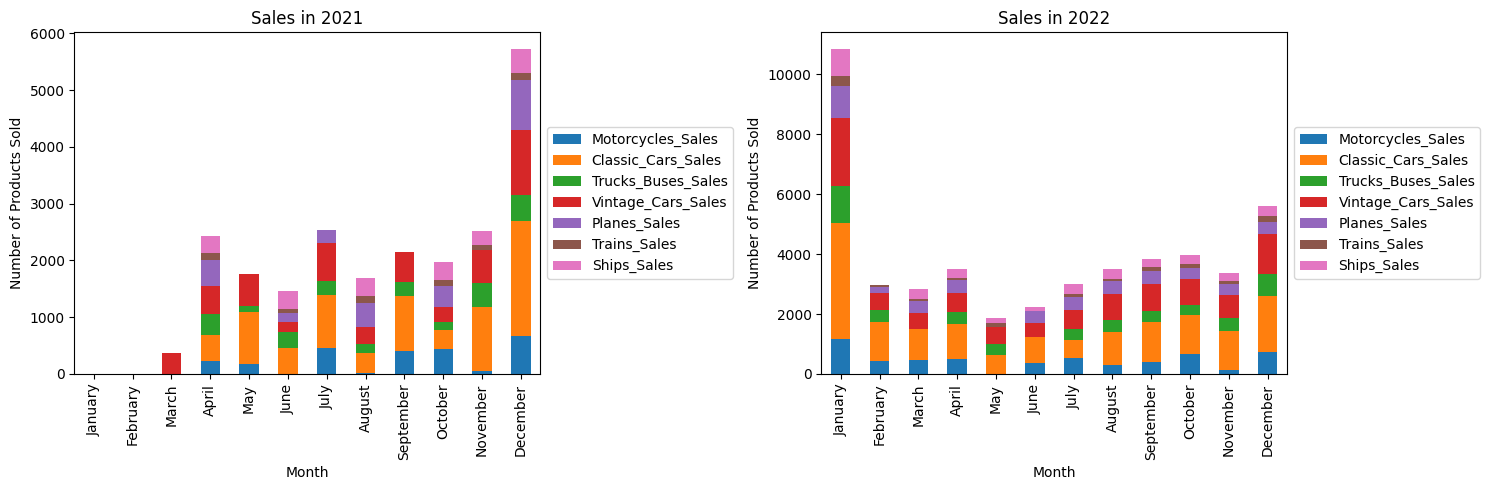

In [3]:
# First, let's combine the 'Sales_Year' and 'Sales_Month' columns, convert them to a string format, and then use pd.to_datetime() to get 
df_SL['Sales_Date'] = pd.to_datetime(df_SL['Sales_Year'].astype(str) + '-' + df_SL['Sales_Month'].astype(str)) 
# Select only the sales columns
sales_cols = ['Motorcycles_Sales', 'Classic_Cars_Sales', 'Trucks_Buses_Sales', 'Vintage_Cars_Sales', 'Planes_Sales', 'Trains_Sales', 'Ships_Sales']
df_sales = df_SL[['Sales_Year', 'Sales_Month'] + sales_cols]
# Filter for the year 2021 and 2022
df_sales = df_sales[df_sales['Sales_Year'].isin([2021, 2022])]
# Convert numeric month to month name
df_sales['Sales_Month'] = df_sales['Sales_Month'].apply(lambda x: calendar.month_name[x])
# Order the months using Categorical
df_sales['Sales_Month'] = pd.Categorical(df_sales['Sales_Month'], categories=calendar.month_name[1:], ordered=True)
# Group by year and month, then sum
df_grouped = df_sales.groupby(['Sales_Year', 'Sales_Month']).sum()
# Reset index
df_grouped.reset_index(inplace=True)
# Create subplot
fig, axs = plt.subplots(1, 2, figsize=(15,5))
for i, year in enumerate([2021, 2022]):
    df_year = df_grouped[df_grouped['Sales_Year'] == year].copy()  # make explicit copy
    df_year.set_index('Sales_Month', inplace=True)
    df_year.drop(columns=['Sales_Year'], inplace=True)
    # Create the stacked bar chart for the year
    df_year.plot(kind='bar', stacked=True, ax=axs[i])
    # Set title and labels
    axs[i].set_title('Sales in {}'.format(year))
    axs[i].set_xlabel('Month')
    axs[i].set_ylabel('Number of Products Sold')
    # Set legend outside of plot
    axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
# Finally let's display the plots
plt.tight_layout()
plt.show()

Comparison and rate of change compared to the same month of the previous year.

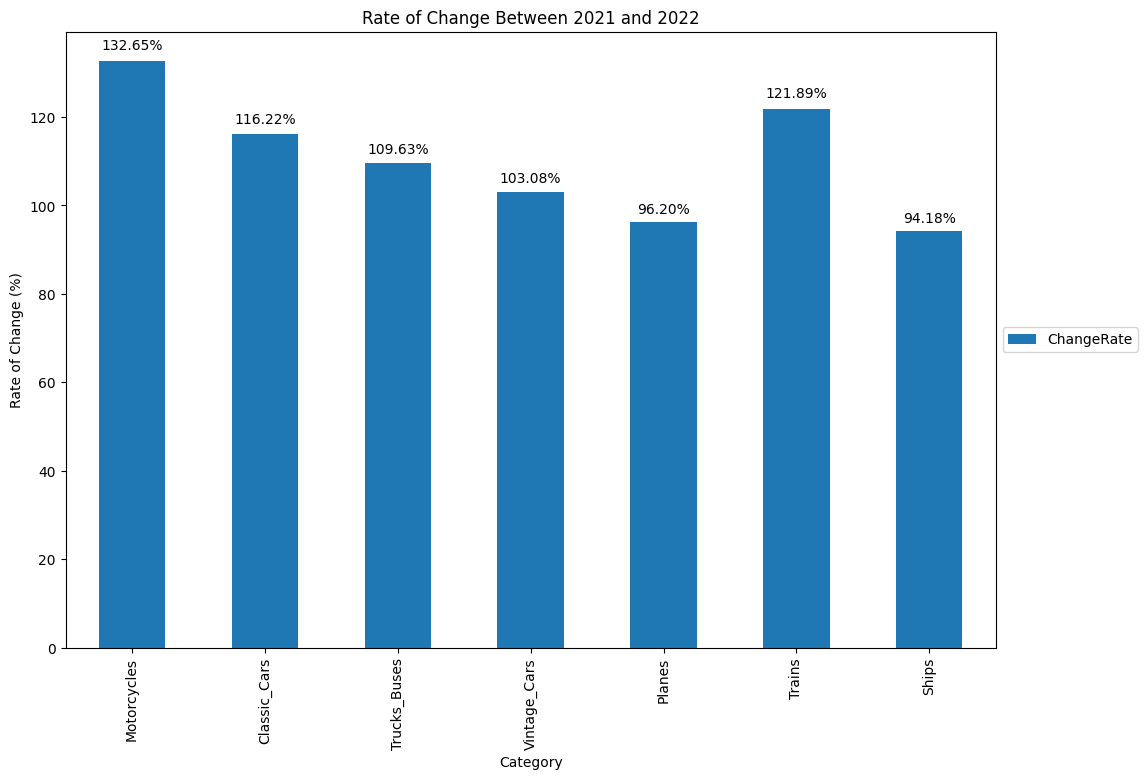

In [4]:
# For the rate of change, let's define the categories first
categories = [('Motorcycles', 'Motorcycles_Sales_PY'), 
              ('Classic_Cars', 'Ccs_PreviousYear'), 
              ('Trucks_Buses', 'Trucks_Buses_Sales_PreviousYear'), 
              ('Vintage_Cars', 'Vintage_Cars_Sales_PreviousYear'), 
              ('Planes', 'Planes_Sales_PreviousYear'), 
              ('Trains', 'Trains_PreviousYear'), 
              ('Ships', 'Ships_PreviousYear')]
# Then calculate the total sales for each category for 2021 and 2022
sales_2021 = df_SL[df_SL['Sales_Year'] == 2021][[cat + '_Sales' for cat, _ in categories]].sum()
sales_2022 = df_SL[df_SL['Sales_Year'] == 2022][[cat + '_Sales' for cat, _ in categories]].sum()
# Now, let's compute the rate of change between 2021 and 2022 for each category
change_rate = (sales_2022 - sales_2021) / sales_2021 * 100
# we have to prepare the dataframe for plotting
df_change_rate = pd.DataFrame(change_rate).reset_index()
df_change_rate.columns = ['Category', 'ChangeRate']
df_change_rate['Category'] = df_change_rate['Category'].apply(lambda x: x.replace('_Sales', ''))
df_change_rate.set_index('Category', inplace=True)
# Plotting the data
ax = df_change_rate.plot(kind='bar', stacked=True, figsize=(12, 8))
# Set title and labels
plt.title('Rate of Change Between 2021 and 2022')
plt.xlabel('Category')
plt.ylabel('Rate of Change (%)')
# We want to display the values on the bars
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2f}%', (x + width/2, y + height*1.02), ha='center')
# Set legend outside of plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# Finally let's show the plot
plt.show()